In [1]:
# 1. Import and Load Dataset #
import pandas as pd
from datasets import load_dataset

# Load 'All Beauty' category from Amazon Reviews 2023
dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_review_All_Beauty", trust_remote_code=True)
df = dataset['full'].to_pandas()
df.head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,5.0,Such a lovely scent but not overpowering.,This spray is really nice. It smells really go...,[],B00YQ6X8EO,B00YQ6X8EO,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1588687728923,0,True
1,4.0,Works great but smells a little weird.,"This product does what I need it to do, I just...",[],B081TJ8YS3,B081TJ8YS3,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1588615855070,1,True
2,5.0,Yes!,"Smells good, feels great!",[],B07PNNCSP9,B097R46CSY,AE74DYR3QUGVPZJ3P7RFWBGIX7XQ,1589665266052,2,True
3,1.0,Synthetic feeling,Felt synthetic,[],B09JS339BZ,B09JS339BZ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,1643393630220,0,True
4,5.0,A+,Love it,[],B08BZ63GMJ,B08BZ63GMJ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,1609322563534,0,True


In [22]:
# 2. Keyword-Based Toxic Labeling #
import re

toxic_keywords = [
    "terrible", "worst", "trash", "stupid", "hate", "idiot",
    "garbage", "dumb", "awful", "cheap knockoff", "disgusting",
    "scam", "horrible", "fraud"
]

def is_toxic(text):
    if not isinstance(text, str):
        return False
    text = text.lower()
    return any(word in text for word in toxic_keywords)

df['is_toxic'] = df['text'].apply(is_toxic)
df['is_toxic'].value_counts()

is_toxic
False    678725
True      22803
Name: count, dtype: int64

In [3]:
# 3. Remove Stopwords and Compute Word Frequency
import nltk
from nltk.corpus import stopwords
from collections import Counter
import re

# Download stopwords only once
try:
    stop_words = set(stopwords.words('english'))
except LookupError:
    nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))

# Clean and tokenize review text
all_text = ' '.join(df['text'].dropna().astype(str)).lower()
tokens = re.findall(r'\b\w+\b', all_text)
filtered_tokens = [word for word in tokens if word not in stop_words]

# Count and rank most frequent tokens
word_counts = Counter(filtered_tokens)
word_freq_df = pd.DataFrame(word_counts.items(), columns=['Word', 'Frequency'])
word_freq_df = word_freq_df.sort_values(by='Frequency', ascending=False).reset_index(drop=True)
word_freq_df.head(20)

,Word,Frequency
0,hair,188062
1,br,150584
2,product,141436
3,great,137068
4,love,128360
5,like,127587
6,use,117164
7,good,96495
8,one,86037
9,really,72284


In [23]:
print(df['is_toxic'].value_counts())

is_toxic
False    678725
True      22803
Name: count, dtype: int64


In [24]:
# 4. Create Train and Validation Datasets #
from sklearn.model_selection import train_test_split

# Use weak labels and sample 2000 reviews
df = df[['text', 'is_toxic']].dropna()
df['is_toxic'] = df['is_toxic'].astype(int)
df_sampled = df.sample(n=2000, random_state=42).reset_index(drop=True)

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df_sampled['text'].tolist(),
    df_sampled['is_toxic'].tolist(),
    test_size=0.2,
    random_state=42
)

In [25]:
print("Train label distribution:\n", pd.Series(train_labels).value_counts(normalize=True))
print("Val label distribution:\n", pd.Series(val_labels).value_counts(normalize=True))

Train label distribution:
 0    0.96875
1    0.03125
Name: proportion, dtype: float64
Val label distribution:
 0    0.965
1    0.035
Name: proportion, dtype: float64


In [26]:
from sklearn.model_selection import train_test_split

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df_sampled['text'],
    df_sampled['is_toxic'],
    test_size=0.2,
    random_state=42,
    stratify=df_sampled['is_toxic']  # this is key
)


In [29]:
train_texts = list(map(str, train_texts))
val_texts = list(map(str, val_texts))

In [30]:
# 5. Tokenization with BERT #
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

In [35]:
# 6. Wrap Encodings in PyTorch Dataset #
import torch
from torch.utils.data import Dataset

class ToxicReviewDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = list(labels)  # 🔧 Make sure labels are a list (not a Series)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            key: torch.tensor(val[idx]) for key, val in self.encodings.items()
        } | {
            'labels': torch.tensor(self.labels[idx])
        }

train_dataset = ToxicReviewDataset(train_encodings, train_labels)
val_dataset = ToxicReviewDataset(val_encodings, val_labels)

In [36]:
# 7. Load Model and Training Arguments #
from transformers import BertForSequenceClassification, TrainingArguments

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
training_args = TrainingArguments(
    output_dir="./results",
    logging_dir="./logs",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_steps=10
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [37]:
# 8. Train the Model #
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

trainer.train()

Step,Training Loss
10,0.310700
20,0.241500
30,0.127500
40,0.229000
50,0.064100
60,0.300200
70,0.122700
80,0.114600
90,0.007100
100,0.188700


TrainOutput(global_step=600, training_loss=0.07276877995890875, metrics={'train_runtime': 1217.8064, 'train_samples_per_second': 3.942, 'train_steps_per_second': 0.493, 'total_flos': 315733266432000.0, 'train_loss': 0.07276877995890875, 'epoch': 3.0})

In [41]:
# 9. Evaluate Model #
from sklearn.metrics import classification_report
import numpy as np

# Run prediction on validation set
raw_preds = trainer.predict(val_dataset)

# Extract predictions and ground truths
pred_labels = np.argmax(raw_preds.predictions, axis=1)
true_labels = raw_preds.label_ids

# Display classification metrics
print(classification_report(
    true_labels, pred_labels,
    labels=[0, 1],
    target_names=["not toxic", "toxic"],
    zero_division=0
))


/usr/local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


              precision    recall  f1-score   support

   not toxic       0.99      1.00      1.00       387
       toxic       1.00      0.77      0.87        13

    accuracy                           0.99       400
   macro avg       1.00      0.88      0.93       400
weighted avg       0.99      0.99      0.99       400



In [42]:
# Save the Model #
trainer.save_model("./toxic-comment-bert")
tokenizer.save_pretrained("./toxic-comment-bert")

('./toxic-comment-bert/tokenizer_config.json',
 './toxic-comment-bert/special_tokens_map.json',
 './toxic-comment-bert/vocab.txt',
 './toxic-comment-bert/added_tokens.json')

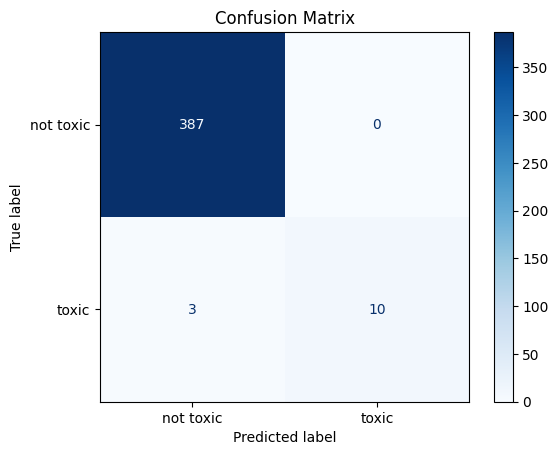

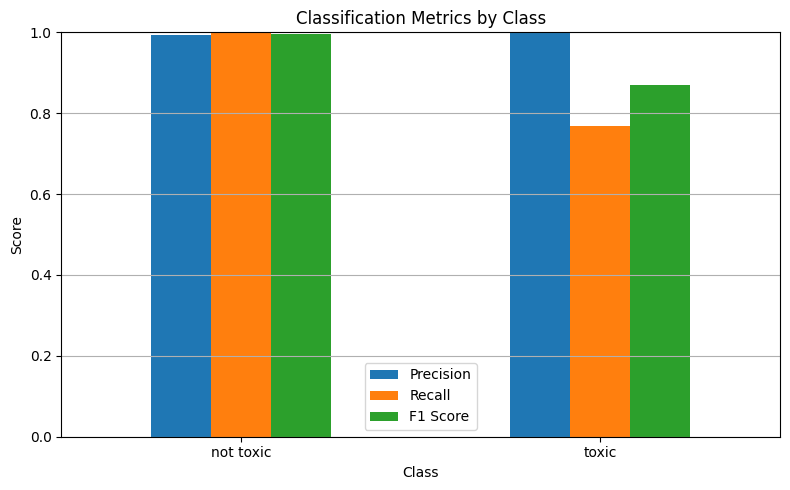

In [43]:
# Confusion Matrix + Classification Metrics Plot #
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score

# Confusion matrix
cm = confusion_matrix(true_labels, pred_labels, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["not toxic", "toxic"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Bar plot of precision, recall, F1
precision = precision_score(true_labels, pred_labels, labels=[0,1], average=None, zero_division=0)
recall = recall_score(true_labels, pred_labels, labels=[0,1], average=None, zero_division=0)
f1 = f1_score(true_labels, pred_labels, labels=[0,1], average=None, zero_division=0)

metrics_df = pd.DataFrame({
    "Class": ["not toxic", "toxic"],
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1
})

metrics_df.set_index("Class").plot(kind="bar", ylim=(0, 1), figsize=(8, 5))
plt.title("Classification Metrics by Class")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.grid(axis="y")
plt.tight_layout()
plt.show()


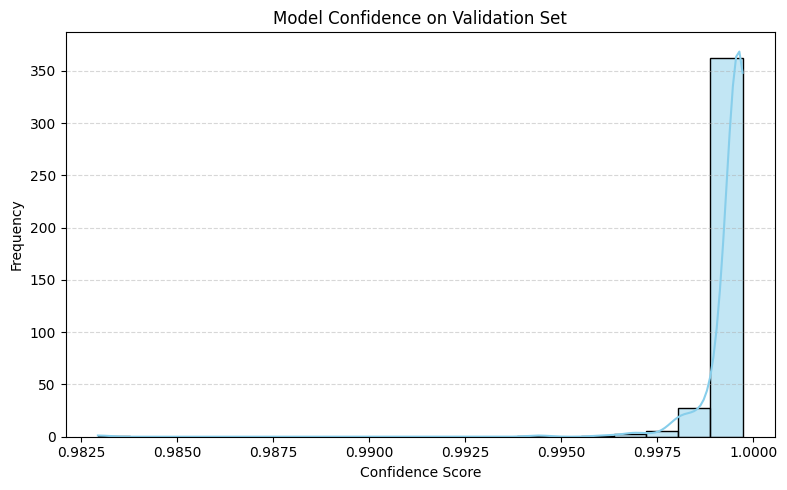

In [47]:
import torch.nn.functional as F

# Get model probabilities
probs = F.softmax(torch.tensor(raw_preds.predictions), dim=1).numpy()
confidences = probs.max(axis=1)

# Plot histogram of confidences
plt.figure(figsize=(8, 5))
sns.histplot(confidences, bins=20, kde=True, color="skyblue")
plt.title("Model Confidence on Validation Set")
plt.xlabel("Confidence Score")
plt.ylabel("Frequency")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
